# A Bayesian Model for News Reporting {-}

*Nicholas Lines*

# Environment Setup

In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import arviz as az
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import graphviz
import os
import pymc3 as pm
from pymc3 import Model, Normal, HalfNormal, Bernoulli, Deterministic, Uniform
from pymc3 import find_MAP

In [3]:
import scipy.stats as st

In [4]:
from tqdm.notebook import tqdm

# A Generative Model for News Information

We wish to model the information network by which a news reporter can gather facts about the news topics of interest to them. While we will use vocabulary related to the application of gathering information about news topics, we note that this task is analagous to many other information-gathering-and-fusion processes. 

Consider a reporter who must stay informed about $n_j$ news topics, indexed by $j$. The reporter cannot observe the facts related to these news topics directly, and relies on a network of first-hand observers to inform the reporter. This network consists of $n_i$ observers, indexed by $i$, who each provide an observation at each time step $t$ of $n_t$ timesteps. These observations, labeled $o_{i,j,t}$ (for observer $i$ speaking about topic $j$ at time $t$) are the only information provided to the reporter.

Many techniques have been proposed to derive "facts" from text streams and other media, but we will not include these steps. Instead, we will assume that each news topic $j$ produces a single binary "fact" called $f_{j,t}$ at each time step $t$. (For example, the sports topic might yield facts such as "The tigers beat the rams on Saturday," which can be represented as a 1 or 0 for true or false.) The fact is then observed by each observer. However, we wish to model the fact that not all observers are are equally aware of all newsworthy subjects, and not all observers will pass on their information at each time step. Therefore, we insist on the following dependencies.

1. The binary fact for each topic and each timestep is sampled from a Bernoulli distribution $f_{j,t} \sim Bern(\delta_j)$ where $\delta_j\sim Unif(0,1)$ represents the bias of this news topic toward 1-valued facts. 
2. Whether an observer will report their observation or not is represented by the binary variable $\tau_{i,j,t} \sim Bern(\epsilon_{i,j})$ where $\epsilon_{i,j}\sim Unif(0,1)$ represents that observer's bias toward reporting about this news topic.
3. Whether an observer is well-informed about this topic's fact at time $t$ is represented by the binary variable $a_{i,j,t} \sim Bern(\beta_{i,j})$ where $\beta_{i,j}\sim Unif(0,1)$ is a hyperparameter representing how well-informed the observer is on this topic on average. This hyperparameter is the variable of most interest for us.
4. Let $\tilde{x}$ represent `not` $x$ for a binary variable $x$. We will use a uniform random binary variable $r_{i,j,t} \sim Bern(0.5)$. The observer's report to the reporter is 
$$o_{i,j,t} = \tau_{i,j,t}(a_{i,j,t}f_{j,t} + \tilde{a_{i,j,t}}r_{i,j,t}) + 2\tilde{\tau_{i,j,t}},$$
meaning that if the observer is aware and chooses to report at this timestep, they report the fact $f_{j,t}$ with no alteration; if the observer is unaware, the observer reports 1 or 0 with equal probability; and if the observer chooses not to report, a 2 is returned, signifying that no information was passed on.
5. The reporter then constructs $$b_j = mode_i(\{o_{i,j,t} : o_{i,j,t}\neq2\})$$ as an approximation to $f_{j,t}$, i.e. the reporter's best guess at the true fact.  

This model is shown in the diagram below.

![](../Images/reporting_network.jpg)

We should make a few observations about this naive construction before continuing. 

1. First, the approximation $b_j \approx f_{j,t}$ is not really legitimate because it could well be that all observers agreed to lie. Really $b_j$ tells us nothing more than the consensus of observations about the fact. This fact is important in situations where we suspect that there is not consensus or that the consensus of our observers is unreliable. 
2. The model as stated leaves each topic's network entirely independent of the other topics, so there is no real need for the outermost plate in the diagram: this was included solely to remind us of this assumption and to indicate that this problem scales in topics $j$. 
3. The purpose for laying out this generative model is to help us strategize how to learn the observer awareness hyperparameter, $\beta_{i,j}$, which will allow us to reduce the network by cutting all edges $o_{i,j,t} - b_{j,t}$ when $\beta_{i,j} < \rho$ for some threshold $\rho$.
4. We are not interested in recovering any other hyperparameters in this situation. These exist solely to lend verisimilitude to the model.
5. If we allow $\lvert\delta_j-0.5\rvert$ to grow too small, the inference problem gets much harder.

# Extremely Simple Inference  

Let's consider how we could approximate $\beta_{i,j}$ using the assumed distributions. If we condition on $\tau_{i,j,t}=1$ we restrict ourselves to a reveiw of the informative reports from a single observer, i.e. $$\{ o_{i,j,t}: o_{i,j,t}\neq 2, i=\bar{i} \},$$
and we can write 
$$ o_{i,j,t} = a_{i,j,t} f_{j,t} + \tilde{a}_{i,j,t} r_{i,j,t}.$$

We can quickly describe the probability distribution for $o_{i,j,t}$ under these conditions using a probability table (since these are all binary variables). We recall that the parameter of each Bernoulli random variable represents the probability that variable equals one. (For simplicity we will drop the subscripts for the table.)  


| $o$ | $a$ | $f$ | $r$ | $P(a)$   | $P(f)$   | $P(r)$ | 
|-----|-----|-----|-----|----------|----------|--------|
| 0   | 1   | 0   | 0   | $\beta$  |$1-\delta$| 0.5 (always) |
| 1   | 1   | 1   | 0   | $\beta$  |$\delta$  | 0.5    |
| 1   | 1   | 1   | 1   | $\beta$  |$\delta$  | 0.5    |
| 0   | 1   | 0   | 1   | $\beta$  |$1-\delta$| 0.5    |
| 1   | 0   | 1   | 1   |$1-\beta$ |$\delta$  | 0.5    |
| 1   | 0   | 0   | 1   |$1-\beta$ |$1-\delta$| 0.5    |
| 0   | 0   | 1   | 0   |$1-\beta$ |$\delta$  | 0.5    |
| 0   | 0   | 0   | 0   |$1-\beta$ |$1-\delta$| 0.5    |

Each of $\beta,\delta,$ and $r$ are mutually independent variables, so their joint probability is the product of their marginal probabilities. By summing up the joint probabilities of combinations that lead us to $o_{\bar{i},j,t}=1$ we have

\begin{align}
P(o_{\bar{i},j,t}=1) &= 0.5(\beta_{\bar{i},j}\delta_j + \delta_j - \beta_{\bar{i},j,t}\delta_j + 1 - \beta_{\bar{i},j,t} - \delta_j + \beta_{\bar{i},j,t}\delta_j + \beta_{\bar{i},j,t}\delta_j)\\
       &= 0.5(-\beta_{\bar{i},j,t} + \beta_{\bar{i},j,t}\delta_j + 1)
\end{align}

We would reach the same result with much less work using conditional probabilities (factors), since 
\begin{align}
P(o_{\bar{i},j,t}=1) &= P(o_{\bar{i},j,t}=1 \mid a_{\bar{i},j,t}=0) P(a_{\bar{i},j,t}=0) + P(o_{\bar{i},j,t}=1 \mid a_{\bar{i},j,t}=1) P(a_{\bar{i},j,t}=1)\\
&= 0.5(1-\beta_{\bar{i},j}) + \delta_j \beta_{\bar{i},j}.
\end{align}

Solving for $\beta$ gives us
$$\beta_{\bar{i},j,t} = \frac{2P(o_{\bar{i},j,t}=1) - 1}{2\delta_j - 1}.$$

We could approximate 
$$\delta_j \approx \hat{\delta_j} = \frac{ \# \{o_{i,j,t} : o_{i,j,t}=1\}}{ \# \{o_{i,j,t} : o_{i,j,t}\neq 2 \} },$$

i.e. we use the sample mean of the informative observations to approximate the probability that a generated fact equals 1 (an extension of the approximation $b_{j,t}=\hat{f}_{j,t}\approx f_{j,t}$). But we already have the observed mean
$$\hat{\delta_j} = \bar{b_{j,t}},$$
which immediately fills that role.

Our statistic for $P(o_{\bar{i},j,t}=1)$ is the observed probability
$$ P(o_{\bar{i},j,t}=1) = \frac{ \# \{o_{\bar{i},j,t} : o_{\bar{i},j,t}=1\}}{ \# \{o_{\bar{i},j,t} : o_{\bar{i},j,t}\neq 2 \} }.$$

Now we can make the approximation

\begin{align}
\beta_{i,j}\approx \hat{\beta_{i,j}} &= \frac{2 \frac{ \# \{o_{\bar{i},j,t} : o_{\bar{i},j,t}=1\}}{ \# \{o_{\bar{i},j,t} : o_{\bar{i},j,t}\neq 2 \} } -1}{2\hat{\delta_j}-1}\\
&= \frac{2 \frac{ \# \{o_{\bar{i},j,t} : o_{\bar{i},j,t}=1\}}{ \# \{o_{\bar{i},j,t} : o_{\bar{i},j,t}\neq 2 \} } -1}{2\frac{ \# \{o_{i,j,t} : o_{i,j,t}=1\}}{ \# \{o_{i,j,t} : o_{i,j,t}\neq 2 \} } - 1}.
\end{align}

# Simulating Data with this Model

We want to create an artificial dataset so we can observe this model at work, and hopefully show how to recover the desired hyperparameter.

In [5]:
def bin_not(n):
    '''Just switch 1 and 0.'''
    return 1 - 1*n

In [6]:
True ^ True

False

In [7]:
x=array([1,0,0,1,0])
t = 0.5
print(x<t)
print(x<2)
(x<t) ^ (x<2)

[False  True  True False  True]
[ True  True  True  True  True]


array([ True, False, False,  True, False])

In [8]:
def proportionate_threshold_agreement(x,y,t=0.5):
    """Determine how similar two n-long arrays are in a threshold sense.
    
    This function first labels which entries of x are less than t and which 
    entries of y are less than t, then sums up how many disagreements there
    are between these two label vectors, and divides this by the length n.
    That gives us the proportionate disagreement; we subtract from 1 to get 
    the proportionate agreement.
    """
    return (1-((x<t)^(y<t)).sum()/x.shape[0])

In [17]:
n_ts = [10, 100, 500, 1000, 5000, 10000]
n_j = 1 # One news topic
n_i = 20 # observers
n_t = 1000 # timesteps
n_d = 10 # number of deltas to try
average_norms = []
average_agreements = []
average_accuracies = []
for n_t in tqdm(n_ts):
#for n_i in tqdm([10,20,50]):
    norms = []
    agreements = []
    accuracies = []
    for d in range(n_d):
        delta = st.uniform.rvs(0,1,n_j)
        epsilon = st.uniform.rvs(0,1,n_i)
        beta = st.uniform.rvs(0,1,n_i)
        f = st.bernoulli(delta[0]).rvs(n_t)
        tau = array([st.bernoulli(epsilon_ij).rvs(n_t) for epsilon_ij in epsilon])
        a = array([st.bernoulli(beta_ij).rvs(n_t) for beta_ij in beta])
        r = array([st.bernoulli(0.5).rvs(n_t) for i in range(n_i)])
        o = array([[tau[i][t] * (a[i][t] * f[t] + bin_not(a[i][t])*r[i][t]) + 2 * bin_not(tau[i][t]) for i in range(n_i)] for t in range(n_t)])
        #o = array([[1 * (a[i][t] * f[t] + bin_not(a[i][t])*r[i][t]) + 0 * bin_not(tau[i][t]) for i in range(n_i)] for t in range(n_t)])
        # We need to drop any timestep where we got absolutely no information.
        drop_rows = argwhere(np.all(o == 2, axis=1)).flatten()
        o = delete(o,drop_rows,0)
        n_t = o.shape[0]
        b = array([st.mode([oit for oit in o[t] if oit!=2])[0][0] for t in range(n_t)])
        f = delete(f,drop_rows)
        accuracies.append(1-(abs(b-f).sum()/b.shape[0]))
        #print(f"The approximation b for f is {100*(1-(abs(b-f).sum()/b.shape[0]))}% accurate")
        p_o_i_bar_1 = [(o[:,i]==1).sum()/((o[:,i]!=2).sum()) for i in range(n_i)] 
        #delta_hat_j = (o==1).sum()/((o!=2).sum()) 
        delta_hat_j = mean(b)
        beta_hat_j = array([(2 * p_i - 1) / (2*delta_hat_j - 1) for p_i in p_o_i_bar_1])
        #beta_hat_j = array([(2 * p_i - 1) / (delta[0] - 1) for p_i in p_o_i_bar_1])
        norms.append(norm(beta_hat_j - beta))
        agreements.append(proportionate_threshold_agreement(beta_hat_j, beta, 0.5))
    average_norms.append((mean(norms), std(agreements)))
    average_agreements.append((mean(agreements), std(agreements)))
    average_accuracies.append((mean(accuracies), std(accuracies)))

  0%|          | 0/6 [00:00<?, ?it/s]

In [21]:
average_norms

[nan, nan, 0.9646777104925176, nan, 2.5291914505568975, 0.8183796856189692]

In [22]:
average_agreements

[(0.635, 0.08381527307120104),
 (0.785, 0.12051970793193949),
 (0.82, 0.11445523142259598),
 (0.8, 0.09486832980505139),
 (0.85, 0.161245154965971),
 (0.8800000000000001, 0.12288205727444507)]

In [23]:
average_accuracies

[(0.9400000000000001, 0.06633249580710798),
 (0.9400000000000001, 0.05639148871948672),
 (0.9732, 0.021469979040511424),
 (0.9468, 0.0338815584057168),
 (0.9616740708141627, 0.0258807363814197),
 (0.9339200000000002, 0.05548702190602772)]

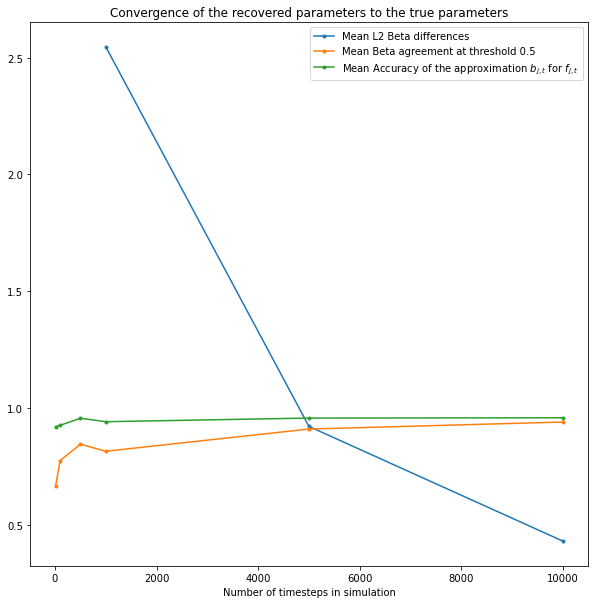

In [15]:
figure(figsize=(10,10))
plot(n_ts, average_norms, '.-', label="Mean L2 Beta differences")
plot(n_ts, average_agreements, '.-', label="Mean Beta agreement at threshold 0.5")
plot(n_ts, average_accuracies, '.-', label="Mean Accuracy of the approximation $b_{j,t}$ for $f_{j,t}$")
legend();
xlabel("Number of timesteps in simulation");
title("Convergence of the recovered parameters to the true parameters");

# Next steps

The next steps for this project are as follows.

1. Demonstrate how to prune reporting edges from uninformed observers.  

    a. Prune by convergence of $\hat{\beta}$  
    
    b. Prune by thresholding (some minimum number of timesteps)  
    
2. Show that this results in approximations of the fact variable comparable to the unpruned version.

## Pseudocode for the Remaining Work

We'll now describe the same steps using pseudocode.

```Python
set threshold_for_min_iterations
set threshold_awareness
set threshold_convergence
for delta in deltas:
    set iterations = 0
    set c_pruned_observers = list()
    set t_pruned_observers = list()
    set beta_hats = dict()
    draw epsilons
    draw betas
    for timestep in timesteps:
        iterations += 1
        draw fact
        for observer in observers:
            draw a
            draw tau
            draw r
            form o
            form beta_hat
            update beta_hats[observer]
        create b
        create t_pruned_b
        create c_pruned_b
        for observer in observers:
            if |beta_hat[observer][-1]-beta_hat[observer][-2]| < threshold_convergence:
                c_pruned_observers.append(observer)
            if iterations > threshold_for_min_iterations:
                if beta_hat[observer][-1] < threshold_awareness:
                    t_pruned_observers.append(observer)
        
        compare b, c_pruned_b and t_pruned_b to f
```

## PYMC3 approach

In [59]:
n_j = 1 # One news topic
n_i = 1 # observers
n_t = 1 # timesteps
n_d = 1 # number of deltas to try

In [60]:
reporter_model = Model()
with reporter_model:
    delta = Uniform(name="delta", lower=0, upper=1, shape=1)
    epsilon = Uniform(name="epsilon", lower=0, upper=1, shape=n_i)
    betas = Uniform(name="beta", lower=0, upper=1, shape=n_i)
    f = Bernoulli(name="f", p=delta, shape=n_t)
#    taus = []
#     fs = []
#     rs = []
#     avals = []
#     os = []
#     randos = []
#     for t in range(n_t):
             
      taus.append([Bernoulli(name="tau_"+str(i)+"_"+str(t), p=epsilons[i], shape=1) for i in range(n_i)])
#         avals.append([Bernoulli(name="a_"+str(i)+"_"+str(t), p=betas[i], shape=1) for i in range(n_i)])
#         rs.append([Bernoulli(name="r_"+str(i)+"_"+str(t), p=0.5, shape=1) for i in range(n_i)])
#         os.append([Normal(name="o_"+str(i)+"_"+str(t), mu=taus[t][i] * (avals[t][i] * fs[t] + \
#             (1-avals[t][i])*rs[t][i]) + 2*(taus[t][i]-1),sigma=0.1,shape=1) for i in range(n_i)])    

In [48]:
reporter_model = Model()
with reporter_model:
    delta = Uniform(name="delta", lower=0, upper=1, shape=n_j)
    epsilons = [Uniform(name="epsilon_"+str(i), lower=0, upper=1, shape=1) for i in range(n_i)]
    betas = [Uniform(name="beta_"+str(i), lower=0, upper=1, shape=1) for i in range(n_i)]
    taus = []
    fs = []
    rs = []
    avals = []
    os = []
    randos = []
    for t in range(n_t):
        fs.append(Bernoulli(name="f_"+str(t), p=delta, shape=1))     
        taus.append([Bernoulli(name="tau_"+str(i)+"_"+str(t), p=epsilons[i], shape=1) for i in range(n_i)])
        avals.append([Bernoulli(name="a_"+str(i)+"_"+str(t), p=betas[i], shape=1) for i in range(n_i)])
        rs.append([Bernoulli(name="r_"+str(i)+"_"+str(t), p=0.5, shape=1) for i in range(n_i)])
        os.append([Normal(name="o_"+str(i)+"_"+str(t), mu=taus[t][i] * (avals[t][i] * fs[t] + \
            (1-avals[t][i])*rs[t][i]) + 2*(taus[t][i]-1),sigma=0.1,shape=1) for i in range(n_i)])    

In [55]:
with reporter_model:
    trace = pm.sample(1)


KeyboardInterrupt



In [ ]:
trace

In [ ]:
az.plot_trace(trace, var_names=["pi", "qi"], compact=True);

In [ ]:
reporter_model.

In [ ]:
        
    #trace = sample(1000)

In [28]:
reporter_model = Model()
with reporter_model:
    delta = Uniform(name="delta", lower=0, upper=1, shape=n_j)
    f = Bernoulli(name="f", p=delta, shape=n_t)
    epsilon = Uniform(name="epsilon", lower=0, upper=1, shape=n_i)
    beta = Uniform(name="beta", lower=0, upper=1, shape=n_i)
    a = Bernoulli(name="a", p=beta, shape=(n_i,n_t))
    tau = Bernoulli(name="tau", p=epsilon, shape=(n_i,n_t))
    r = Bernoulli(name="r", p=0.5, shape=(n_i,n_t))
    o = Deterministic("o", tau * (a * f + (1-a)*r) + 2*(Tau-1))
    #trace = sample(1000)

ValueError: operands could not be broadcast together with shapes (20,1000) (20,) 